## Training Functions

### Plot graph

In [2]:
import nnfs
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from nnfs.datasets import spiral_data, vertical_data

nnfs.init()

def plot_prediction_performance(
    model: list | tuple,
    X, y,
    num_points: int = 100,
    device: str = 'cpu'
) -> None:
    """Plots the performance of the model in the spiral dataset with 3 categories"""
    def probabilities_to_rgb(probabilities_array):
        """ Maps an array of probabilities to RGB colors."""
        # Ensure that probabilities sum up to 1 for all data points
        if not torch.all(torch.isclose(torch.sum(probabilities_array, dim=1), torch.tensor(1.0).to(device))):
            raise ValueError("Probabilities must sum up to 1 for all data points.")
        
        # Map probabilities to RGB channels (0-255) for all data points
        r, g, b = (probabilities_array * 255).to(torch.int32).T
        
        # Return the RGB colors as a torch tensor
        return torch.stack((r, g, b), dim=1)

    # Create a meshgrid of points in the (-1,1)x(-1,1) space
    x_val = torch.linspace(-1, 1, num_points)
    y_val = torch.linspace(-1, 1, num_points)
    x_grid, y_grid = torch.meshgrid(x_val, y_val, indexing='xy')
    
    # Flatten the grids into 1D arrays
    x_flat = x_grid.flatten()
    y_flat = y_grid.flatten()
    
    # Combine the flattened arrays into an Nx2 array
    XX_tuples = torch.stack((x_flat, y_flat), dim=1).to(device)
    
    # Perform a forward pass through the network
    with torch.no_grad():
        model.eval()
        logits = model(XX_tuples)
        probabilities = torch.softmax(logits, dim=1)
    
    rgb_colors = probabilities_to_rgb(probabilities)
    probs_2d = rgb_colors.reshape(num_points, num_points, 3)
    
    # Assumed 3 categories - change this if different
    colors = ['r' if label == 0 else 'g' if label == 1 else 'b' for label in y]
    
    plt.imshow(probs_2d.cpu().numpy(), extent=(-1, 1, -1, 1), interpolation='bilinear')
    plt.scatter(X[:, 0].cpu(), -X[:, 1].cpu(), c=colors)
    plt.show()

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize

def plot_evolution(w_Cs, w_A, window_size=20):
    w_A = np.convolve(w_A, np.ones(window_size), 'valid') / window_size
    time = np.linspace(0, 1, len(w_A))

    w_Cs = np.array(w_Cs)
    w_Cs = w_Cs.T

    fig, ax = plt.subplots(figsize=(8, 6))
    
    for w_C in w_Cs:
        # smooth the data with a moving average
        w_C = np.convolve(w_C, np.ones(window_size), 'valid') / window_size
        # Create segments for the line
        points = np.array([w_A, w_C]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)

        # Create a line collection
        norm = Normalize(vmin=time.min(), vmax=time.max())  # Normalize time values
        lc = LineCollection(segments, cmap="viridis", norm=norm, alpha=0.7)
        lc.set_array(time)  # Use time to color the line
        ax.add_collection(lc)

        # plot initial and final points
        ax.scatter(w_A[0], w_C[0], c='r', alpha=1, zorder=10)
        ax.scatter(w_A[-1], w_C[-1], c='b', alpha=1, zorder=10)
   
        
    ax.autoscale()  # Adjust axis limits
    ax.set_xlabel("W_A")
    ax.set_ylabel("W_C")
    ax.grid(True) 
    

    # Add a colorbar to show time progression
    cbar = plt.colorbar(lc, ax=ax)
    cbar.set_label("Time")
    
    ax.set_title("Final result: {:.3f}".format(np.mean(w_Cs[:, -1])))
    plt.show()

## SHD

In [4]:
from torch.optim import Optimizer

class SHD(Optimizer):
    
    def __init__(self, param_groups, lr=0.01, weight_decay=0.1, t=[1]):
        defaults = dict(lr=lr, weight_decay=weight_decay, t=t)
        super(SHD, self).__init__(param_groups, defaults)
        self.t = []
        self.counter = 1

        layer_counter = 0
        previous_num_rows = 0
        group_C = param_groups[0]
        t = group_C['t']
        for param in group_C['params']:
            if len(param.data.shape) == 1:
                self.t.append(t[layer_counter-1] * previous_num_rows)
            else:
                self.t.append(t[layer_counter])
                previous_num_rows = param.data.shape[1]
                layer_counter += 1
        
        self.learning_rate_C = param_groups[0]['lr']
        self.weight_decay_C = param_groups[0]['weight_decay']
        self.learning_rate_A = param_groups[1]['lr']
        self.weight_decay_A = param_groups[1]['weight_decay']

        self.params_Cs = [param_groups[i]['params'] for i in range(len(param_groups)-1)]
        self.params_A = param_groups[-1]['params']
            

    def step(self):
        # Update each parameter
        for stuff in zip(*self.params_Cs, self.params_A, self.t):
            param_Cs = stuff[:-2]
            param_A = stuff[-2]
            t = stuff[-1]
            param_Cs_with_grad = [param_C for param_C in param_Cs if param_C.grad is not None]
            if len(param_Cs_with_grad) == 0:
                continue

            self.update_A(param_Cs_with_grad, param_A)

            # update params of C matrix
            if self.counter % t == 0:
                if len(param_Cs[0].data.shape) == 1:
                    update_index = -1
                else:
                    update_index = (self.counter // t) % param_Cs[0].data.shape[1]
                self.update_C(param_Cs, param_A, update_index)
        self.counter += 1

    
    def update_A(self, layer_Cs, layer_A):
        # update the weights of the Auxiliary matrix with the gradients of C and weight decay
        mean_grad = torch.mean(torch.stack([layer_C.grad for layer_C in layer_Cs]), dim=0)
        layer_A.data += -self.learning_rate_A * (mean_grad + self.weight_decay_A * layer_A.data * torch.abs(mean_grad))


    def update_C(self, layer_Cs, layer_A, update_index):
        # Concatenate all layer_Cs into a single tensor
        concatenated_Cs = torch.cat([layer_C.data.unsqueeze(0) for layer_C in layer_Cs], dim=0)
        
        # Stack n copies of layer_A to match the batch size of concatenated_Cs
        stacked_A = layer_A.data.unsqueeze(0).expand(len(layer_Cs), * layer_A.data.shape)
        
        if update_index == -1:
            # Perform batched update for all indices
            concatenated_Cs += self.learning_rate_C * (
                stacked_A - self.weight_decay_C * concatenated_Cs * torch.abs(stacked_A)
            )
        else:
            # Perform batched update for the specified column/index
            concatenated_Cs[:, :, update_index] += self.learning_rate_C * (
                stacked_A[:, :, update_index]
                - self.weight_decay_C * concatenated_Cs[:, :, update_index] * torch.abs(stacked_A[:, :, update_index])
            )
        
        # Split concatenated_Cs back into individual layers
        updated_layer_Cs = torch.split(concatenated_Cs, 1, dim=0)
        for i, layer_C in enumerate(layer_Cs):
            layer_C.data = updated_layer_Cs[i].squeeze(0)  # Remove the batch dimension

## Training

In [5]:
def training_run(X, y, model, optimizer, loss_fn, epochs, batch_size=1):
    
    loss = []
    accuracy = []
    # save in a list the historical values of a weight of dense2_C and the same neuron in dense2_A
    neuron = 0
    weight = 0
    w_C = [[model.Cs[i].l1.weight[neuron][weight].item() for i in range(len(model.Cs))]]
    w_A = [model.A.l1.weight[neuron][weight].item()]
    
    for _ in range(epochs):
        model.train()
        # reshuffle the data
        perm = torch.randperm(len(X))
        X = X[perm]
        y = y[perm]
        # batch the data
        X_batched = torch.split(X, batch_size)
        y_batched = torch.split(y, batch_size)
        for x, y_true in zip(X_batched, y_batched):
            output = model(x)
            l = loss_fn(output, y_true)

            # backward pass
            l.backward()

            # update params
            optimizer.step()
            optimizer.zero_grad()

            # save in a list the historical values of a weight of dense2_C and the same neuron in dense2_A
            w_C.append([model.Cs[i].l1.weight[neuron][weight].item() for i in range(len(model.Cs))])
            w_A.append(model.A.l1.weight[neuron][weight].item())
        model.eval()
        real_output = model(X)
        loss.append(loss_fn(real_output, y).item())
        if isinstance(loss_fn, nn.CrossEntropyLoss):
            correct_predictions = torch.sum(torch.argmax(real_output, axis=1) == y)
            accuracy.append(correct_predictions.item() / len(y))
    return loss, accuracy, w_C, w_A


### Network

In [6]:
class Cs_A_Network(nn.Module):
            
    def __init__(self, Network, num_c_networks=32, device='cpu'):
        super(Cs_A_Network, self).__init__()

        self.Cs = nn.ModuleList([
            Network(zeroes=False, device=device) 
            for _ in range(num_c_networks)
        ])
        self.A = Network(zeroes=True, device=device)
        self.N = Network(zeroes=False, device=device)
        
    def forward(self, x):
        batch_size = x.shape[0]
        if model.training:
            x = nn.parallel.parallel_apply(self.Cs[:batch_size], x)
            x = torch.stack(x, dim=0)
            return x
        else:
            # construct a model whose weights are the average of the weights of the C models
            # and pass the input through this model
            with torch.no_grad():
                # Initialize accumulators for each parameter
                avg_state_dict = {key: torch.zeros_like(value) for key, value in self.Cs[0].state_dict().items()}

                # Accumulate parameters from all `C` networks
                for c_model in self.Cs:
                    for key, value in c_model.state_dict().items():
                        avg_state_dict[key] += value

                # Compute averages
                num_c_models = len(self.Cs)
                for key in avg_state_dict:
                    avg_state_dict[key] /= num_c_models

                # Load averaged parameters into `N`
                self.N.load_state_dict(avg_state_dict)

            # Forward pass through the averaged model
            return self.N(x)

### Spiral_data

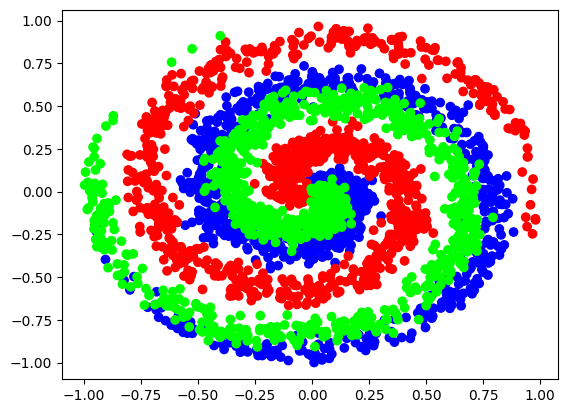

In [17]:
nnfs.init()
X_np, y_np = spiral_data(samples=1000, classes=3)

# plot spiral data
plt.scatter(X_np[:, 0], X_np[:, 1], c=y_np, cmap='brg')

In [6]:
class Network_Spiral(nn.Module):
    def __init__(self, zeroes=False, device='cpu'):
        super(Network_Spiral, self).__init__()
        self.l1 = nn.Linear(2, 64).to(device)
        self.l2 = nn.Linear(64, 3).to(device)
        
        if zeroes:
            self.l1.weight.data.fill_(0)
            self.l2.weight.data.fill_(0)
            for param in self.l1.parameters():
                param.requires_grad = False
            for param in self.l2.parameters():
                param.requires_grad = False
        else:
            self.l1.weight.data = torch.randn_like(self.l1.weight.data)#* 0.01
            self.l2.weight.data = torch.randn_like(self.l2.weight.data)#* 0.01

        self.l1.bias.data.fill_(0)
        self.l2.bias.data.fill_(0)
            
    def forward(self, x):
        x = torch.relu(self.l1(x))
        x = self.l2(x)
        return x

#### Grid search

In [ ]:
# grid search for hyperparameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
nnfs.init()
batch_size = 32
X_np, y_np = spiral_data(samples=100, classes=3)
X = torch.tensor(X_np, dtype=torch.float32).to(device)
y = torch.tensor(y_np, dtype=torch.int64).to(device)
# shuffle data
indices = torch.randperm(len(X))
X = X[indices]
y = y[indices]

# grid search
learning_rate_C = [1, 2]
learning_rate_A = [0.5, 1]  
t = [[10, 1]]

best_loss = float('inf')
best_accuracy = 0
results = []

for lr_C in learning_rate_C:
    for lr_A in learning_rate_A:
            for t_ in t:
                model = Cs_A_Network(Network_Spiral, num_c_networks=batch_size, device=device)
                optimizer = SHD([
                    {'params': model.Cs[i].parameters(), 'lr': lr_C, 'weight_decay': 0.2, 't': t_} for i in range(batch_size)] + [
                    {'params': model.A.parameters(), 'lr': lr_A, 'weight_decay': 0.2},
                ])
                loss, accuracy, _, _ = training_run(X, y, model, optimizer, nn.CrossEntropyLoss(), 2500, batch_size=batch_size)
                loss = np.mean(loss[-100:])
                accuracy = np.mean(accuracy[-100:])
                print(f'Loss: {loss:.2f}, accuracy: {accuracy:.2f} for params: lr_C: {lr_C}, lr_A: {lr_A}, t: {t_}')
                results.append({
                    'lr_C': lr_C,
                    'lr_A': lr_A,
                    't': t_,
                    'loss': loss,
                    'accuracy': accuracy,
                })
                if loss < best_loss:
                    best_loss = loss
                    best_accuracy = accuracy
                    best_params = f'lr_C: {lr_C}, lr_A: {lr_A}, t: {t_}'

print(f'Best loss: {best_loss}, best accuracy: {best_accuracy} for params: {best_params}')

Loss: 0.82, accuracy: 0.53 for params: lr_C: 1, lr_A: 0.5, t: [10, 1]
Loss: 0.88, accuracy: 0.54 for params: lr_C: 1, lr_A: 1, t: [10, 1]
Loss: 2.12, accuracy: 0.37 for params: lr_C: 2, lr_A: 0.5, t: [10, 1]
Loss: 1.80, accuracy: 0.38 for params: lr_C: 2, lr_A: 1, t: [10, 1]
Best loss: 0.8154610389471054, best accuracy: 0.5273 for params: lr_C: 1, lr_A: 0.5, t: [10, 1]


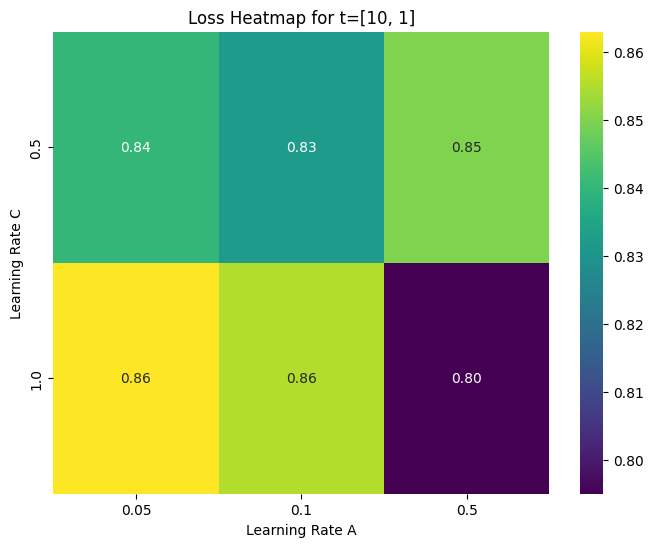

In [45]:
import pandas as pd

# Convert results to DataFrame
df = pd.DataFrame(results)

import seaborn as sns
import matplotlib.pyplot as plt

# Filter by specific `t_` if needed
t_fixed = [10, 1]  # Example
filtered_df = df[df['t'].apply(lambda x: x == t_fixed)]

# Pivot table for heatmap
heatmap_data = filtered_df.pivot(index="lr_C", columns="lr_A", values="loss")

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="viridis")
plt.title(f"Loss Heatmap for t={t_fixed}")
plt.xlabel("Learning Rate A")
plt.ylabel("Learning Rate C")
plt.show()

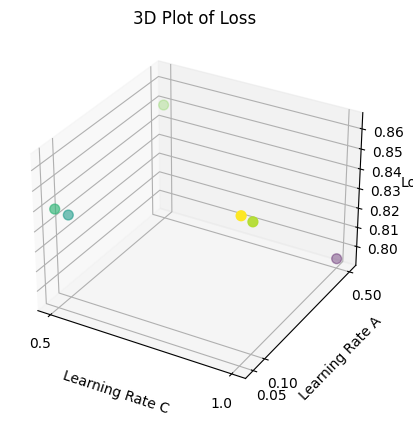

In [46]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Prepare data for 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Extract values
x = df['lr_C']
y = df['lr_A']
z = df['loss']

# Plot
ax.scatter(x, y, z, c=z, cmap='viridis', s=50)
ax.set_xlabel("Learning Rate C")
ax.set_ylabel("Learning Rate A")
ax.set_zlabel("Loss")
ax.set_xticks(learning_rate_C)
ax.set_yticks(learning_rate_A)
plt.title("3D Plot of Loss")
plt.show()

#### Run

/home/ignacio/.local/lib/python3.10/site-packages/torch/nn/modules/linear.py:117: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return F.linear(input, self.weight, self.bias)


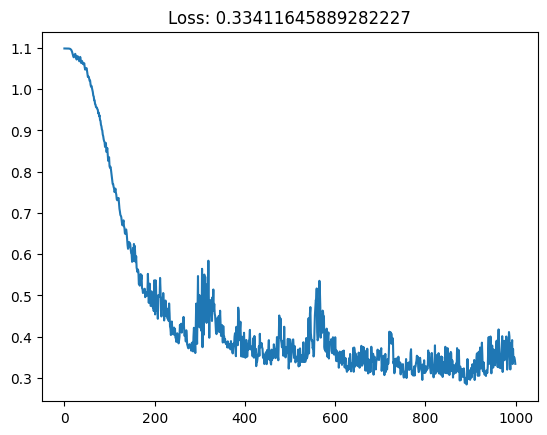

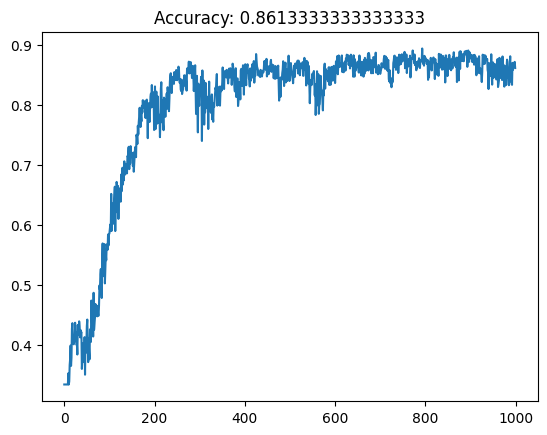

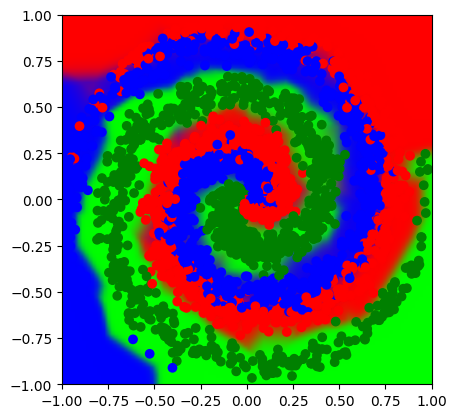

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
nnfs.init()

batch_size = 32
X_np, y_np = spiral_data(samples=1000, classes=3)
X = torch.tensor(X_np, dtype=torch.float32).to(device)
y = torch.tensor(y_np, dtype=torch.int64).to(device)
# shuffle data
indices = torch.randperm(len(X))
X = X[indices]
y = y[indices]

model = Cs_A_Network(Network_Spiral, num_c_networks=batch_size, device=device)

optimizer = SHD([
    {'params': model.Cs[i].parameters(), 'lr': 0.5, 'weight_decay': 0.2, 't': [10, 1]} for i in range(batch_size)] + [
    {'params': model.A.parameters(), 'lr': 0.5, 'weight_decay': 0.2},
])

loss_fn = nn.CrossEntropyLoss()

loss, accuracy, w_C, w_A = training_run(X, y, model, optimizer, loss_fn, 1000, batch_size=batch_size)

plt.plot(loss)
plt.title(f'Loss: {loss[-1]}')
plt.show()

plt.plot(accuracy)
plt.title(f'Accuracy: {accuracy[-1]}')
plt.show()

num_points = 100
plot_prediction_performance(model, X, y, num_points, device)

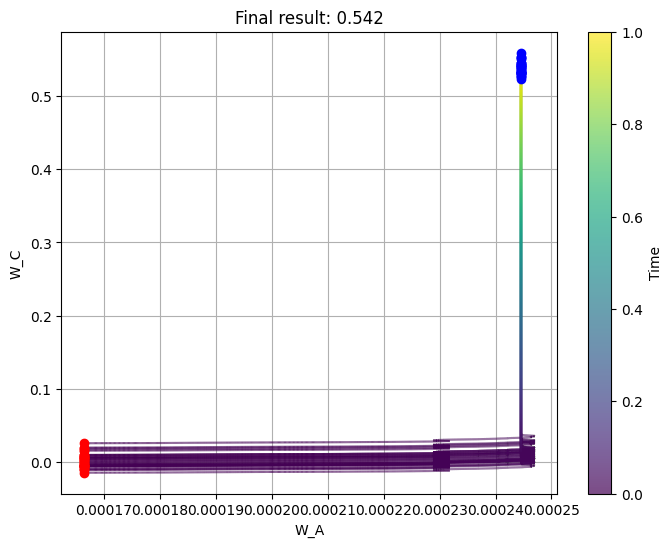

In [22]:
plot_evolution(w_C, w_A, window_size=1000)

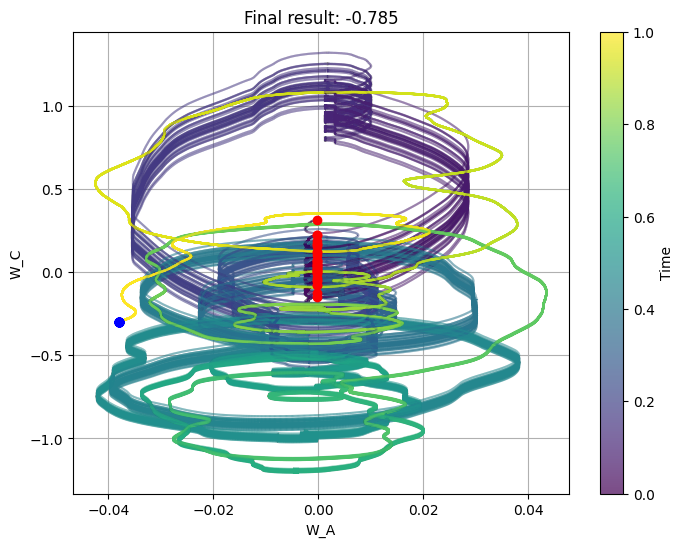

In [15]:
plot_evolution(w_C, w_A, window_size=1000)

Text(0.5, 1.0, 'Evolution of the weights of the C models')

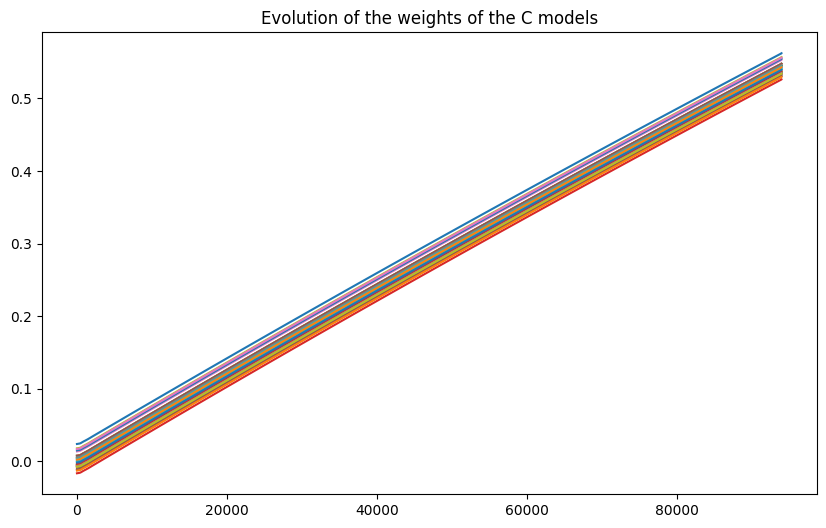

In [23]:
# plot every C in Cs value over the epochs
plt.figure(figsize=(10, 6))
for i in range(len(w_C[0])):
    plt.plot([w_C[j][i] for j in range(len(w_C))])
plt.title('Evolution of the weights of the C models')

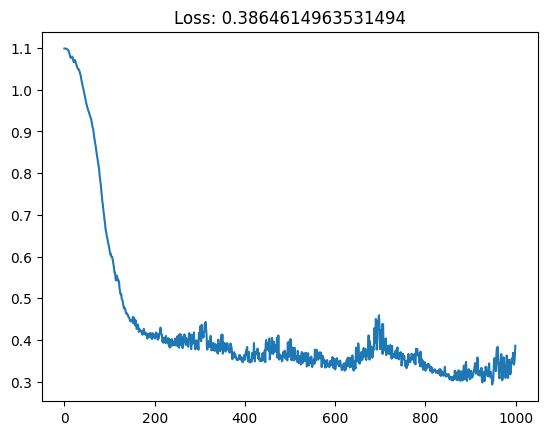

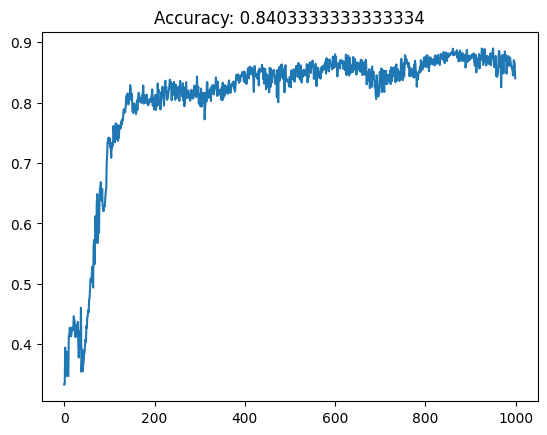

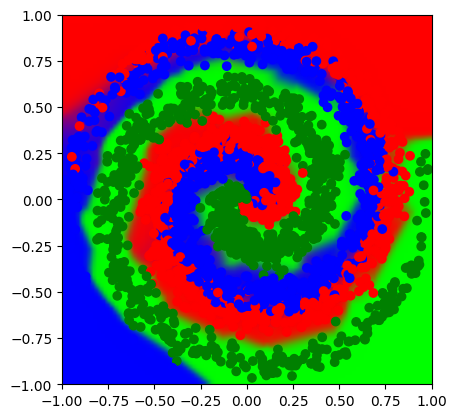

In [25]:
# 0.1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
nnfs.init()

batch_size = 32
X_np, y_np = spiral_data(samples=1000, classes=3)
X = torch.tensor(X_np, dtype=torch.float32).to(device)
y = torch.tensor(y_np, dtype=torch.int64).to(device)
# shuffle data
indices = torch.randperm(len(X))
X = X[indices]
y = y[indices]

model = Cs_A_Network(Network_Spiral, num_c_networks=batch_size, device=device)

optimizer = SHD([
    {'params': model.Cs[i].parameters(), 'lr': 0.5, 'weight_decay': 0.2, 't': [10, 1]} for i in range(batch_size)] + [
    {'params': model.A.parameters(), 'lr': 0.5, 'weight_decay': 0.2},
])

loss_fn = nn.CrossEntropyLoss()

loss, accuracy, w_C, w_A = training_run(X, y, model, optimizer, loss_fn, 1000, batch_size=batch_size)

plt.plot(loss)
plt.title(f'Loss: {loss[-1]}')
plt.show()

plt.plot(accuracy)
plt.title(f'Accuracy: {accuracy[-1]}')
plt.show()

num_points = 100
plot_prediction_performance(model, X, y, num_points, device)

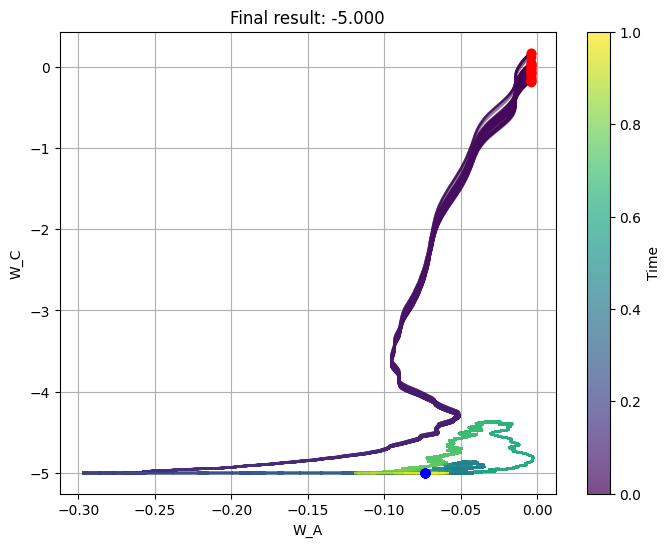

In [26]:
plot_evolution(w_C, w_A, window_size=1000)

Text(0.5, 1.0, 'Evolution of the weights of the C models')

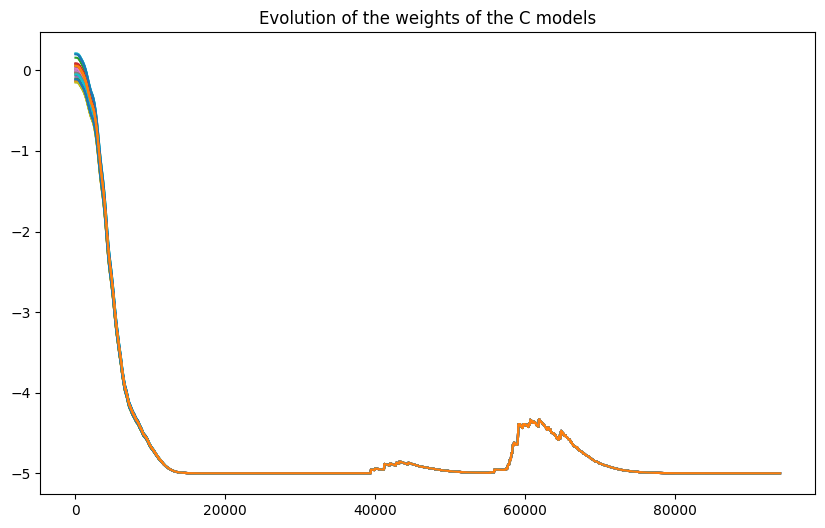

In [28]:
# plot every C in Cs value over the epochs
plt.figure(figsize=(10, 6))
for i in range(len(w_C[0])):
    plt.plot([w_C[j][i] for j in range(len(w_C))])
plt.title('Evolution of the weights of the C models')

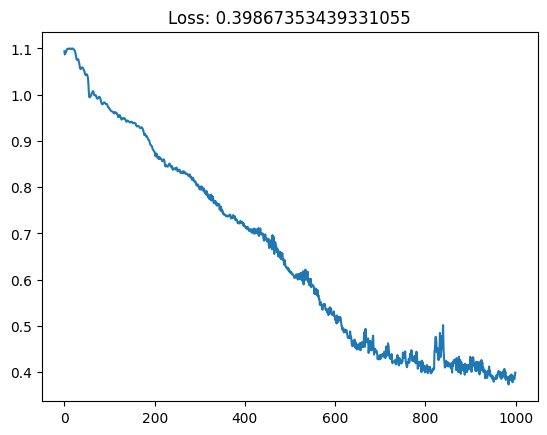

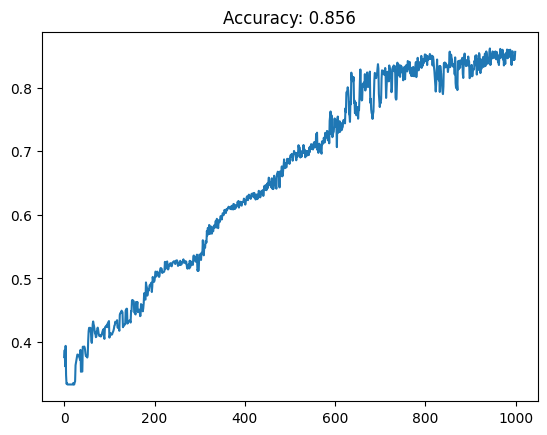

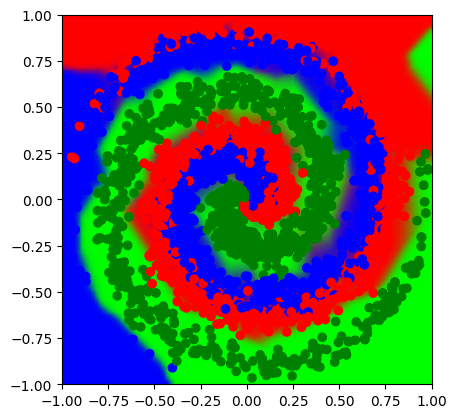

In [30]:
# 1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
nnfs.init()

batch_size = 32
X_np, y_np = spiral_data(samples=1000, classes=3)
X = torch.tensor(X_np, dtype=torch.float32).to(device)
y = torch.tensor(y_np, dtype=torch.int64).to(device)
# shuffle data
indices = torch.randperm(len(X))
X = X[indices]
y = y[indices]

model = Cs_A_Network(Network_Spiral, num_c_networks=batch_size, device=device)

optimizer = SHD([
    {'params': model.Cs[i].parameters(), 'lr': 0.5, 'weight_decay': 0.2, 't': [10, 1]} for i in range(batch_size)] + [
    {'params': model.A.parameters(), 'lr': 0.5, 'weight_decay': 0.2},
])

loss_fn = nn.CrossEntropyLoss()

loss, accuracy, w_C, w_A = training_run(X, y, model, optimizer, loss_fn, 1000, batch_size=batch_size)

plt.plot(loss)
plt.title(f'Loss: {loss[-1]}')
plt.show()

plt.plot(accuracy)
plt.title(f'Accuracy: {accuracy[-1]}')
plt.show()

num_points = 100
plot_prediction_performance(model, X, y, num_points, device)

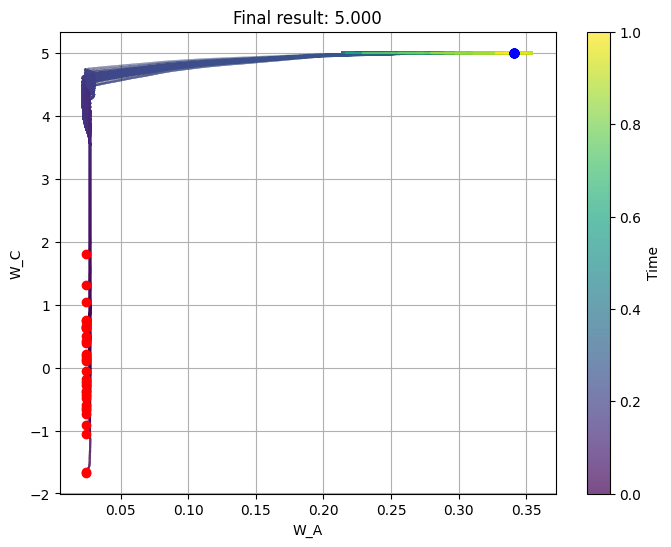

In [31]:
plot_evolution(w_C, w_A, window_size=1000)

Text(0.5, 1.0, 'Evolution of the weights of the C models')

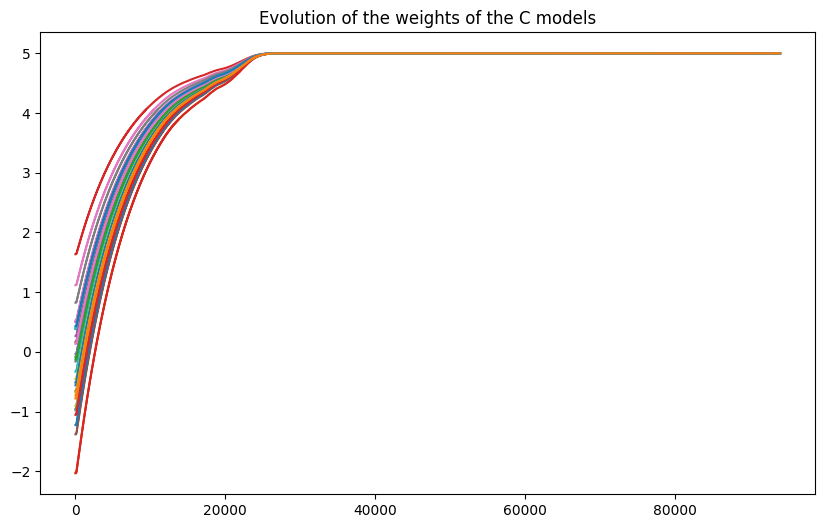

In [32]:
# plot every C in Cs value over the epochs
plt.figure(figsize=(10, 6))
for i in range(len(w_C[0])):
    plt.plot([w_C[j][i] for j in range(len(w_C))])
plt.title('Evolution of the weights of the C models')

### Synthetic data -> regression

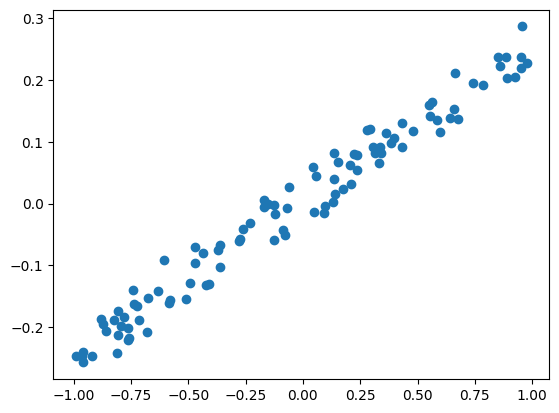

In [7]:
# generate a 100 point dataset for a linear regression problem with 1 feature
def generate_linear_regression_data(num_points=100):
    X = np.random.uniform(-1, 1, (num_points, 1))
    y = 0.25 * X + np.random.normal(0, 0.025, (num_points, 1))
    return X, y

# plot the data
X, y = generate_linear_regression_data(100)
plt.scatter(X, y)

In [8]:
class Network_Linear(nn.Module):
    def __init__(self, zeroes=False, device='cpu'):
        super(Network_Linear, self).__init__()
        self.l1 = nn.Linear(1, 1, bias=False).to(device)

        if zeroes:
            self.l1.weight.data.fill_(0)
            for param in self.l1.parameters():
                param.requires_grad = False
        
        else:
            self.l1.weight.data = torch.randn_like(self.l1.weight.data) * 0.01
    
    def forward(self, x):
        x = self.l1(x)
        return x

In [ ]:
# grid search for hyperparameters
device = 'cpu'
batch_size = 32
X_np, y_np = generate_linear_regression_data(1000)
X = torch.tensor(X_np, dtype=torch.float32).to(device)
y = torch.tensor(y_np, dtype=torch.float32).to(device)

# grid search
learning_rate_C = [0.1, 0.5, 1]
learning_rate_A = [0.05, 0.1, 0.5, 1, 5]
t = [[5]]

best_loss = float('inf')
results = []

for lr_C in learning_rate_C:
    for lr_A in learning_rate_A:
            for t_ in t:
                #model = C_A_Network_linear(batch_size).to(device)
                model = Cs_A_Network(Network_Linear, num_c_networks=batch_size, device=device)
                optimizer = SHD([
                    {'params': model.Cs[i].parameters(), 'lr': lr_C, 'weight_decay': 0.2, 't': t_} for i in range(batch_size)] + [
                    {'params': model.A.parameters(), 'lr': lr_A, 'weight_decay': 0.2},
                ])
                loss, _, _, _ = training_run(X, y, model, optimizer, nn.MSELoss(), epochs=20, batch_size=batch_size)
                loss = np.mean(loss[-5:])
                print(f'Loss: {loss:.2f} for params: lr_C: {lr_C}, lr_A: {lr_A}, t: {t_}')
                results.append({
                    'lr_C': lr_C,
                    'lr_A': lr_A,
                    't': t_,
                    'loss': loss,
                })
                if loss < best_loss:
                    best_loss = loss
                    best_params = f'lr_C: {lr_C}, lr_A: {lr_A}, t: {t_}'

print(f'Best loss: {best_loss} for params: {best_params}')

Loss: 0.03 for params: lr_C: 0.05, lr_A: 0.05, t: [5]
Loss: 0.04 for params: lr_C: 0.05, lr_A: 0.05, t: [10]
Loss: 0.03 for params: lr_C: 0.05, lr_A: 0.1, t: [5]
Loss: 0.03 for params: lr_C: 0.05, lr_A: 0.1, t: [10]
Loss: 0.03 for params: lr_C: 0.05, lr_A: 0.5, t: [5]
Loss: 0.04 for params: lr_C: 0.05, lr_A: 0.5, t: [10]
Loss: 0.03 for params: lr_C: 0.05, lr_A: 1, t: [5]
Loss: 0.04 for params: lr_C: 0.05, lr_A: 1, t: [10]
Loss: 0.03 for params: lr_C: 0.05, lr_A: 5, t: [5]
Loss: 0.04 for params: lr_C: 0.05, lr_A: 5, t: [10]
Loss: 0.17 for params: lr_C: 0.1, lr_A: 0.05, t: [5]
Loss: 0.15 for params: lr_C: 0.1, lr_A: 0.05, t: [10]
Loss: 0.18 for params: lr_C: 0.1, lr_A: 0.1, t: [5]
Loss: 0.15 for params: lr_C: 0.1, lr_A: 0.1, t: [10]
Loss: 0.18 for params: lr_C: 0.1, lr_A: 0.5, t: [5]
Loss: 0.16 for params: lr_C: 0.1, lr_A: 0.5, t: [10]
Loss: 0.18 for params: lr_C: 0.1, lr_A: 1, t: [5]
Loss: 0.16 for params: lr_C: 0.1, lr_A: 1, t: [10]
Loss: 0.17 for params: lr_C: 0.1, lr_A: 5, t: [5]
Los

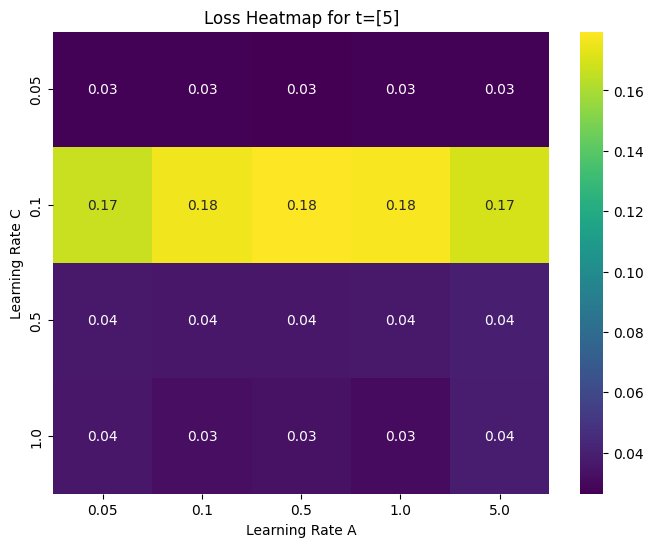

In [41]:
import pandas as pd

# Convert results to DataFrame
df = pd.DataFrame(results)

import seaborn as sns
import matplotlib.pyplot as plt

# Filter by specific `t_` if needed
t_fixed = [5]  # Example
filtered_df = df[df['t'].apply(lambda x: x == t_fixed)]

# Pivot table for heatmap
heatmap_data = filtered_df.pivot(index="lr_C", columns="lr_A", values="loss")

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="viridis")
plt.title(f"Loss Heatmap for t={t_fixed}")
plt.xlabel("Learning Rate A")
plt.ylabel("Learning Rate C")
plt.show()

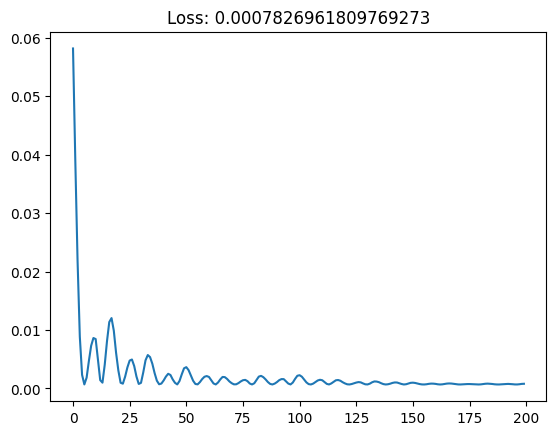

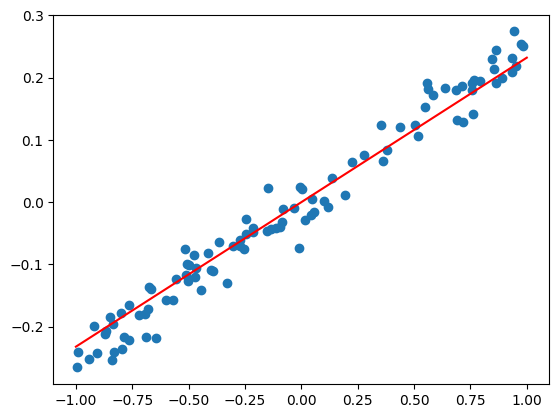

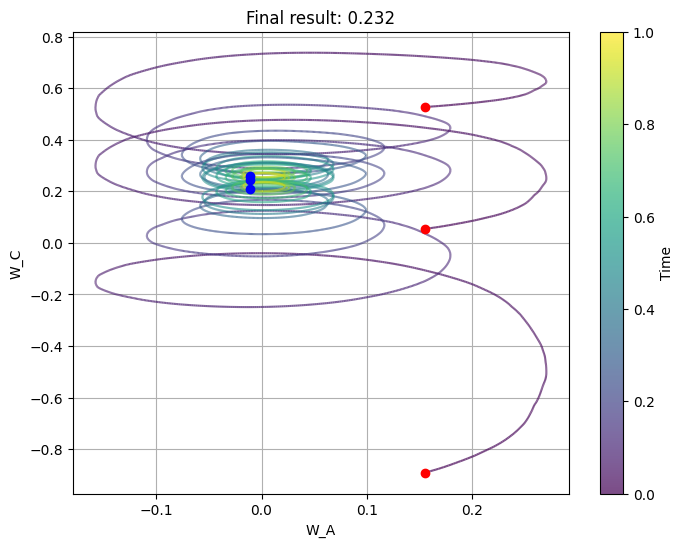

In [13]:
device = 'cpu'
batch_size = 3
X_np, y_np = generate_linear_regression_data(100)
X = torch.tensor(X_np, dtype=torch.float32).to(device)
y = torch.tensor(y_np, dtype=torch.float32).to(device)

model = Cs_A_Network(Network_Linear, num_c_networks=batch_size, device=device)

model.Cs[0].l1.weight.data.fill_(0.5)
model.Cs[1].l1.weight.data.fill_(0)
model.Cs[2].l1.weight.data.fill_(-1)

optimizer = SHD([
    {'params': model.Cs[i].parameters(), 'lr': 0.05, 'weight_decay': 1, 't': [5]} for i in range(batch_size)] + [
    {'params': model.A.parameters(), 'lr': 0.02, 'weight_decay': 1},
])

loss_fn = nn.MSELoss()

loss, _, w_C, w_A = training_run(X, y, model, optimizer, loss_fn, 200, batch_size=batch_size)


plt.plot(loss)
plt.title(f'Loss: {loss[-1]}')
plt.show()

# plot the linear regression line over the data
model.eval()
X_line = torch.tensor([[-1], [1]], dtype=torch.float32).to(device)
output = model(X_line)
y_line = output.detach().cpu().numpy()
plt.scatter(X_np, y_np)
plt.plot([-1, 1], y_line, c='r')
plt.show()

plot_evolution(w_C, w_A, window_size=100)

(-1.1, 1.1)

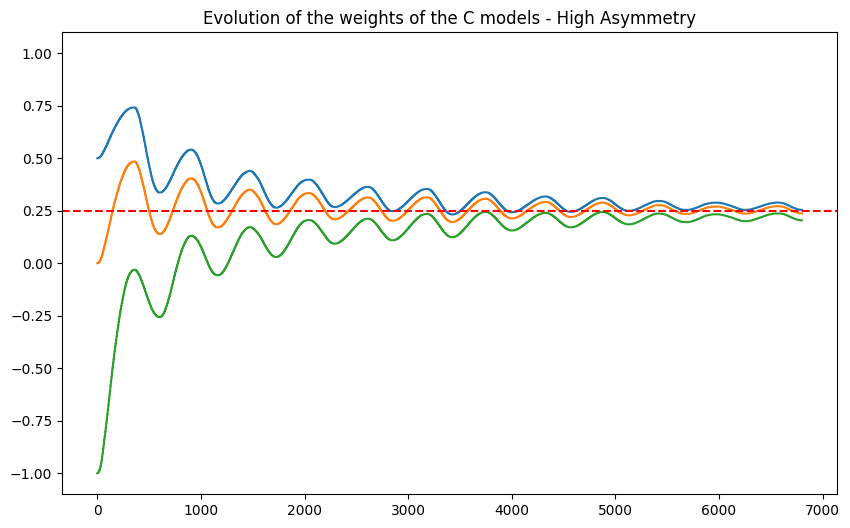

In [15]:
plt.figure(figsize=(10, 6))
for i in range(len(w_C[0])):
    plt.plot([w_C[j][i] for j in range(len(w_C))])
# plot the reference horizontal line at solution y = 1
plt.axhline(y=0.25, color='r', linestyle='--')
plt.title('Evolution of the weights of the C models - High Asymmetry')
# the y axis should go from -1 to 1.1
plt.ylim(-1.1, 1.1)

### Multiple optima

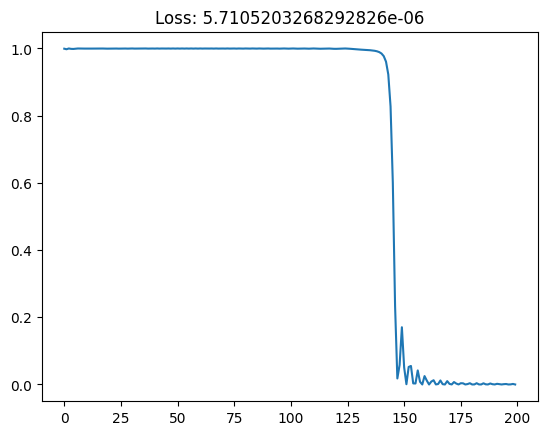

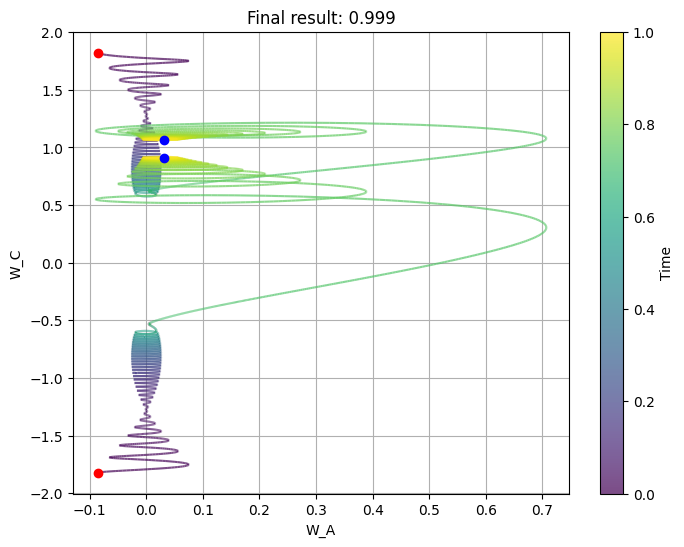

In [115]:
device = 'cpu'
batch_size = 2
X, y = torch.ones((100, 1)).to(device), torch.ones((100, 1)).to(device)

model = Cs_A_Network(Network_Linear, num_c_networks=batch_size, device=device)

model.Cs[0].l1.weight.data.fill_(2)
model.Cs[1].l1.weight.data.fill_(-1.9)
# model.Cs[2].l1.weight.data.fill_(-5)

optimizer = SHD([
    {'params': model.Cs[i].parameters(), 'lr': 0.05, 'weight_decay': 0.5, 't': [5]} for i in range(batch_size)] + [
    {'params': model.A.parameters(), 'lr': 0.01, 'weight_decay': 0.5},
])

def custom_loss(output, y):
    return torch.mean((output**2 - 1) ** 2)
loss_fn = custom_loss

loss, _, w_C, w_A = training_run(X, y, model, optimizer, loss_fn, 200, batch_size=batch_size)

plt.plot(loss)
plt.title(f'Loss: {loss[-1]}')
plt.show()

plot_evolution(w_C, w_A, window_size=100)

Text(0.5, 1.0, 'Evolution of the weights of the C models')

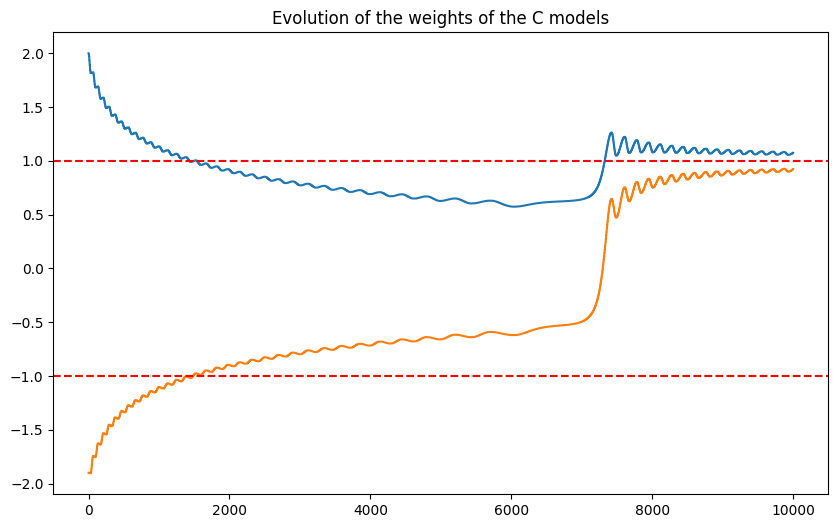

In [116]:
plt.figure(figsize=(10, 6))
for i in range(len(w_C[0])):
    plt.plot([w_C[j][i] for j in range(len(w_C))])
# plot the reference horizontal line at solution y = 1
plt.axhline(y=1, color='r', linestyle='--')
plt.axhline(y=-1, color='r', linestyle='--')
plt.title('Evolution of the weights of the C models')

In [110]:
# grid search for hyperparameters
device = 'cpu'
batch_size = 2
X, y = torch.ones((100, 1)).to(device), torch.ones((100, 1)).to(device)

model = Cs_A_Network(Network_Linear, num_c_networks=batch_size, device=device)

# grid search
C0 = [1.6, 1.7, 1.8, 1.9, 2.0]
C1 = [-2.0, -1.9, -1.8, -1.7, -1.6]

results = []

for c0 in C0:
    for c1 in C1:
            #model = C_A_Network_linear(batch_size).to(device)
            model = Cs_A_Network(Network_Linear, num_c_networks=batch_size, device=device)
            model.Cs[0].l1.weight.data.fill_(c0)
            model.Cs[1].l1.weight.data.fill_(c1)
            optimizer = SHD([
                {'params': model.Cs[i].parameters(), 'lr': 0.1, 'weight_decay': 0.5, 't': [2]} for i in range(batch_size)] + [
                {'params': model.A.parameters(), 'lr': 0.05, 'weight_decay': 0.5},
            ])
            loss, _, _, _ = training_run(X, y, model, optimizer, custom_loss, epochs=120, batch_size=batch_size)
            result = np.mean([model.Cs[0].l1.weight.data.item(), model.Cs[1].l1.weight.data.item()])
            print(f'Result for c0: {c0}, c1: {c1} is {result:.2f}')
            results.append({
                'c0': c0,
                'c1': c1,
                'result': result,    
            })

Result for c0: 1.6, c1: -2.0 is -1.00
Result for c0: 1.6, c1: -1.9 is 1.00
Result for c0: 1.6, c1: -1.8 is 1.00
Result for c0: 1.6, c1: -1.7 is 1.00
Result for c0: 1.6, c1: -1.6 is 0.00
Result for c0: 1.7, c1: -2.0 is -1.00
Result for c0: 1.7, c1: -1.9 is -1.00
Result for c0: 1.7, c1: -1.8 is -1.00
Result for c0: 1.7, c1: -1.7 is 0.00
Result for c0: 1.7, c1: -1.6 is -1.00
Result for c0: 1.8, c1: -2.0 is -1.00
Result for c0: 1.8, c1: -1.9 is -1.00
Result for c0: 1.8, c1: -1.8 is 0.00
Result for c0: 1.8, c1: -1.7 is 1.00
Result for c0: 1.8, c1: -1.6 is -1.00
Result for c0: 1.9, c1: -2.0 is -1.00
Result for c0: 1.9, c1: -1.9 is 0.00
Result for c0: 1.9, c1: -1.8 is 1.00
Result for c0: 1.9, c1: -1.7 is 1.00
Result for c0: 1.9, c1: -1.6 is -1.00
Result for c0: 2.0, c1: -2.0 is 0.00
Result for c0: 2.0, c1: -1.9 is 1.00
Result for c0: 2.0, c1: -1.8 is 1.00
Result for c0: 2.0, c1: -1.7 is 1.00
Result for c0: 2.0, c1: -1.6 is 1.00


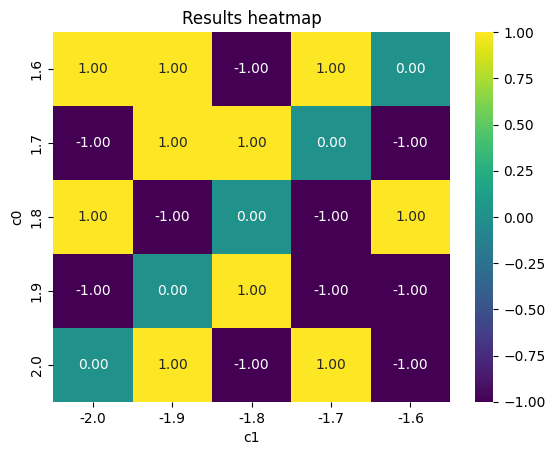

In [109]:
# with t = 1

import pandas as pd
import seaborn as sns

# plot the results in a heatmap
df = pd.DataFrame(results)
# change df values to either -1, 0 or 1 depending on the sign of the result
df['result'] = df['result'].apply(lambda x: 1 if x > 0 else -1 if x < 0 else 0)
df = df.pivot(index='c0', columns='c1', values='result')
sns.heatmap(df, annot=True, fmt=".2f", cmap="viridis")
plt.title("Results heatmap")
plt.show()

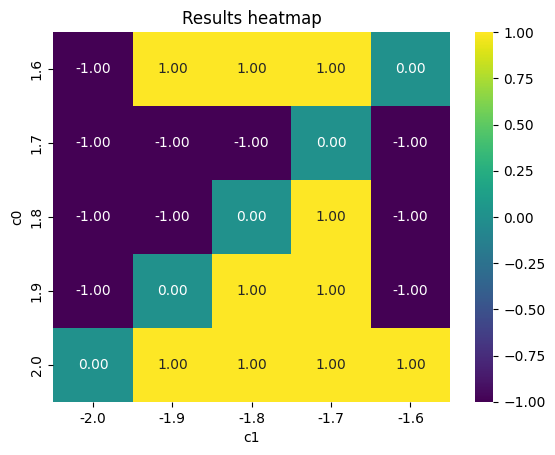

In [112]:
# with t = 2

import pandas as pd
import seaborn as sns

# plot the results in a heatmap
df = pd.DataFrame(results)
# change df values to either -1, 0 or 1 depending on the sign of the result
df['result'] = df['result'].apply(lambda x: 1 if x > 0 else -1 if x < 0 else 0)
df = df.pivot(index='c0', columns='c1', values='result')
sns.heatmap(df, annot=True, fmt=".2f", cmap="viridis")
plt.title("Results heatmap")
plt.show()

### None symmetric optima

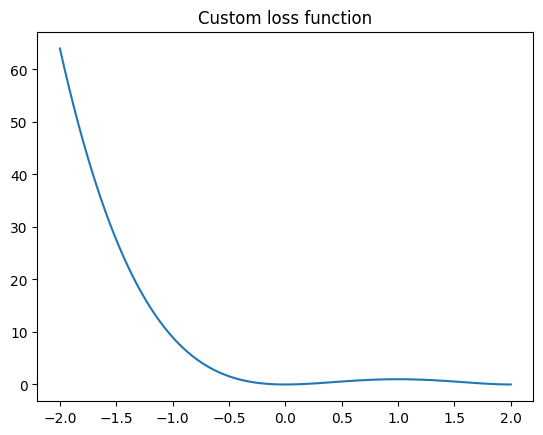

In [147]:
def custom_loss(output, y):
    return (((output-1)**2 - 1)) ** 2

# plot the custom loss function
output = torch.linspace(-2, 2, 100)
output = output.unsqueeze(1)
loss = custom_loss(output, torch.ones_like(output))
plt.plot(output, loss)
plt.title('Custom loss function')
plt.show()

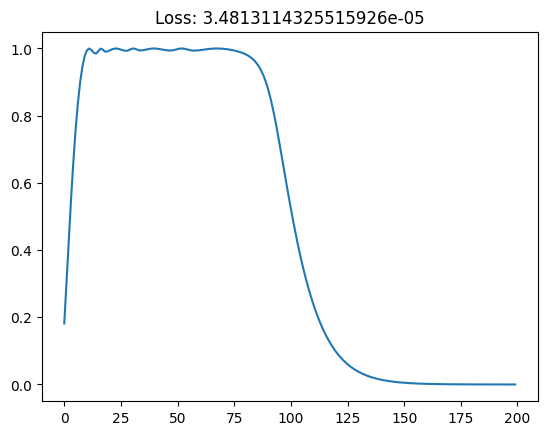

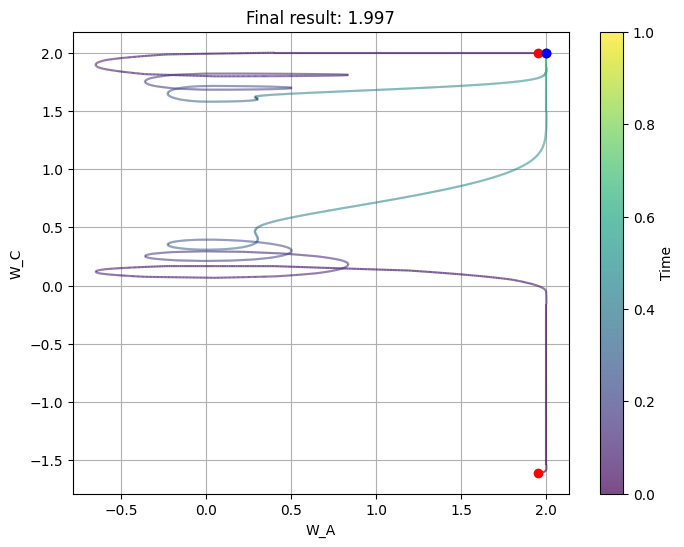

In [205]:
device = 'cpu'
batch_size = 2
X, y = torch.ones((100, 1)).to(device), torch.ones((100, 1)).to(device)

model = Cs_A_Network(Network_Linear, num_c_networks=batch_size, device=device)

model.Cs[0].l1.weight.data.fill_(2)
model.Cs[1].l1.weight.data.fill_(-1.7)
# model.Cs[2].l1.weight.data.fill_(-5)

optimizer = SHD([
    {'params': model.Cs[i].parameters(), 'lr': 0.05, 'weight_decay': 0.5, 't': [50]} for i in range(batch_size)] + [
    {'params': model.A.parameters(), 'lr': 0.01, 'weight_decay': 0.5},
])


def custom_loss(output, y):
    return torch.mean(((output-1)**2 - 1) ** 2)
loss_fn = custom_loss

loss, _, w_C, w_A = training_run(X, y, model, optimizer, loss_fn, 200, batch_size=batch_size)

plt.plot(loss)
plt.title(f'Loss: {loss[-1]}')
plt.show()

plot_evolution(w_C, w_A, window_size=100)

Text(0.5, 1.0, 'Evolution of the weights of the C models')

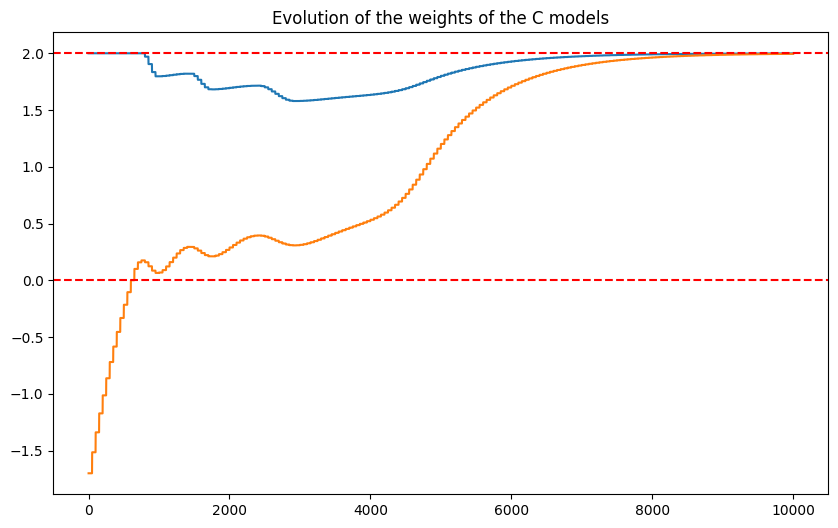

In [206]:
plt.figure(figsize=(10, 6))
for i in range(len(w_C[0])):
    plt.plot([w_C[j][i] for j in range(len(w_C))])
# plot the reference horizontal line at solution y = 1
plt.axhline(y=0, color='r', linestyle='--')
plt.axhline(y=2, color='r', linestyle='--')
plt.title('Evolution of the weights of the C models')

In [213]:
# grid search for hyperparameters
device = 'cpu'
batch_size = 2
X, y = torch.ones((100, 1)).to(device), torch.ones((100, 1)).to(device)

model = Cs_A_Network(Network_Linear, num_c_networks=batch_size, device=device)

def custom_loss(output, y):
    return torch.mean(((output-1)**2 - 1) ** 2)

# grid search
C0 = [0.2, 0.5, 0.8, 1.1, 1.4, 1.7, 2]
C1 = [-2, -1.7, -1.4, -1.1, -0.8, -0.5, -0.2]

results = []

for c0 in C0:
    for c1 in C1:
            #model = C_A_Network_linear(batch_size).to(device)
            model = Cs_A_Network(Network_Linear, num_c_networks=batch_size, device=device)
            model.Cs[0].l1.weight.data.fill_(c0)
            model.Cs[1].l1.weight.data.fill_(c1)
            optimizer = SHD([
                {'params': model.Cs[i].parameters(), 'lr': 0.1, 'weight_decay': 0.5, 't': [20]} for i in range(batch_size)] + [
                {'params': model.A.parameters(), 'lr': 0.05, 'weight_decay': 0.5},
            ])
            loss, _, _, _ = training_run(X, y, model, optimizer, custom_loss, epochs=50, batch_size=batch_size)
            result = np.mean([model.Cs[0].l1.weight.data.item(), model.Cs[1].l1.weight.data.item()])
            print(f'Result for c0: {c0}, c1: {c1} is {result:.2f}')
            results.append({
                'c0': c0,
                'c1': c1,
                'result': result,    
            })

Result for c0: 0.2, c1: -2 is 2.00
Result for c0: 0.2, c1: -1.7 is 0.02
Result for c0: 0.2, c1: -1.4 is 0.03
Result for c0: 0.2, c1: -1.1 is 0.02
Result for c0: 0.2, c1: -0.8 is 0.02
Result for c0: 0.2, c1: -0.5 is 0.02
Result for c0: 0.2, c1: -0.2 is 0.01
Result for c0: 0.5, c1: -2 is 2.00
Result for c0: 0.5, c1: -1.7 is 2.00
Result for c0: 0.5, c1: -1.4 is 2.00
Result for c0: 0.5, c1: -1.1 is 0.03
Result for c0: 0.5, c1: -0.8 is 0.02
Result for c0: 0.5, c1: -0.5 is 0.02
Result for c0: 0.5, c1: -0.2 is 0.05
Result for c0: 0.8, c1: -2 is 2.00
Result for c0: 0.8, c1: -1.7 is 2.00
Result for c0: 0.8, c1: -1.4 is 2.00
Result for c0: 0.8, c1: -1.1 is 2.00
Result for c0: 0.8, c1: -0.8 is 2.00
Result for c0: 0.8, c1: -0.5 is 0.03
Result for c0: 0.8, c1: -0.2 is 0.05
Result for c0: 1.1, c1: -2 is 2.00
Result for c0: 1.1, c1: -1.7 is 2.00
Result for c0: 1.1, c1: -1.4 is 2.00
Result for c0: 1.1, c1: -1.1 is 2.00
Result for c0: 1.1, c1: -0.8 is 2.00
Result for c0: 1.1, c1: -0.5 is 2.00
Result fo

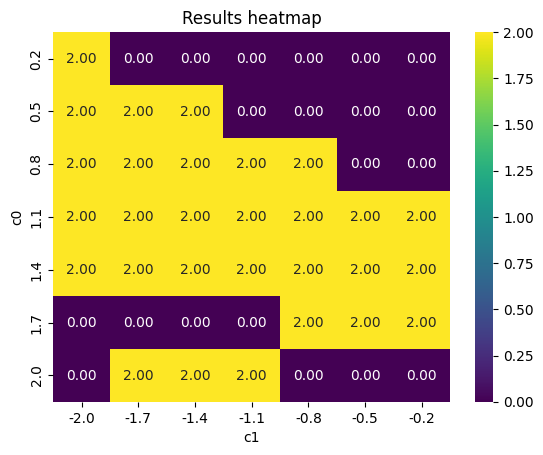

In [214]:
import pandas as pd
import seaborn as sns

# plot the results in a heatmap
df = pd.DataFrame(results)
# change df values to either -1, 0 or 1 depending on the sign of the result
df['result'] = df['result'].apply(lambda x: 2 if x > 1 else 0 if x < 1 else 1)
df = df.pivot(index='c0', columns='c1', values='result')
sns.heatmap(df, annot=True, fmt=".2f", cmap="viridis")
plt.title("Results heatmap")
plt.show()

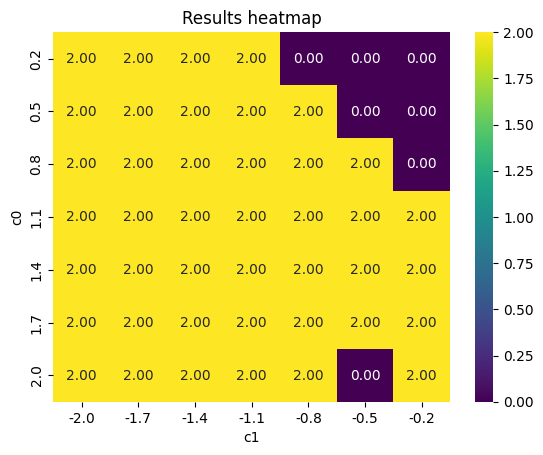

In [159]:
# with t = 2

import pandas as pd
import seaborn as sns

# plot the results in a heatmap
df = pd.DataFrame(results)
# change df values to either -1, 0 or 1 depending on the sign of the result
df['result'] = df['result'].apply(lambda x: 2 if x > 1 else 0 if x < 1 else 1)
df = df.pivot(index='c0', columns='c1', values='result')
sns.heatmap(df, annot=True, fmt=".2f", cmap="viridis")
plt.title("Results heatmap")
plt.show()

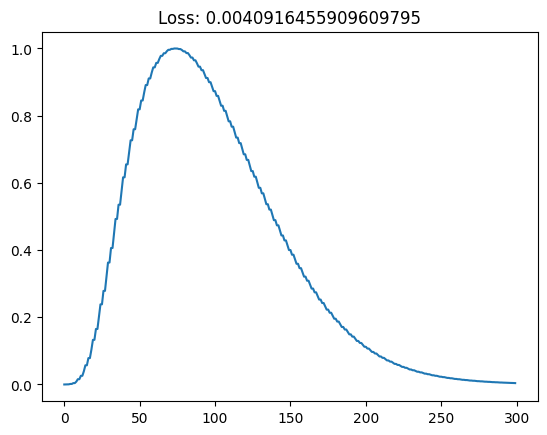

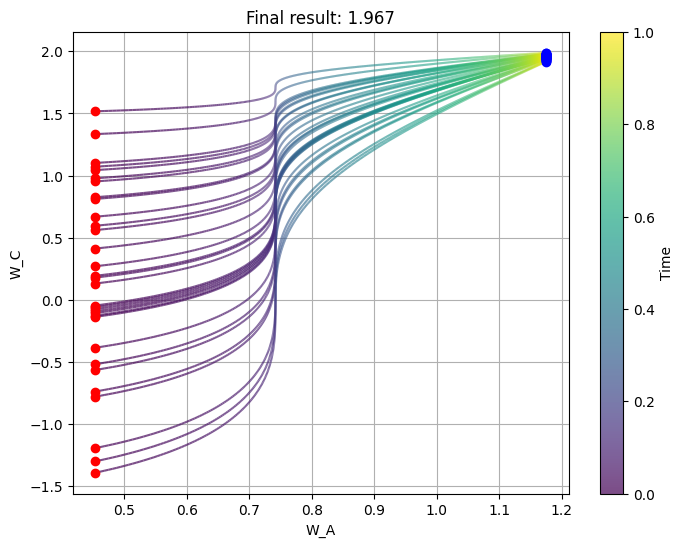

Text(0.5, 1.0, 'Evolution of the weights of the C models')

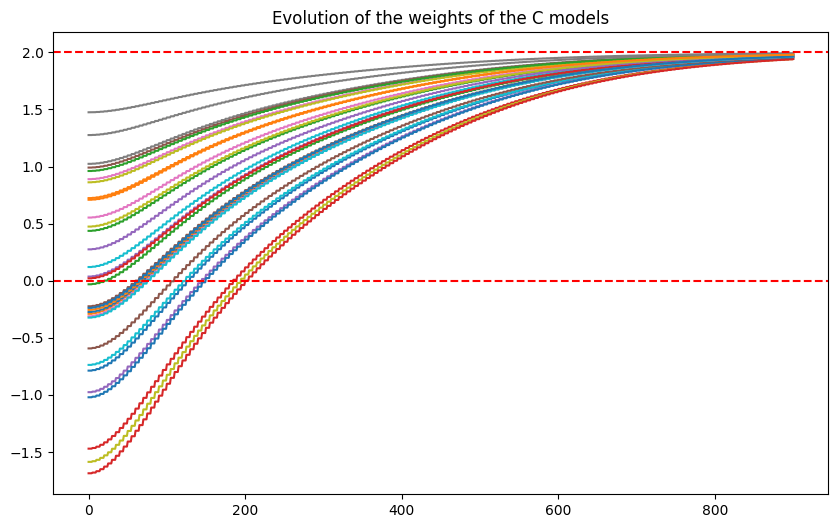

In [219]:
class Network_Linear(nn.Module):
    def __init__(self, zeroes=False, device='cpu'):
        super(Network_Linear, self).__init__()
        self.l1 = nn.Linear(1, 1, bias=False).to(device)

        if zeroes:
            self.l1.weight.data.fill_(0)
            for param in self.l1.parameters():
                param.requires_grad = False
        
        else:
            self.l1.weight.data = torch.randn_like(self.l1.weight.data) * 0.8
    
    def forward(self, x):
        x = self.l1(x)
        return x

device = 'cpu'
batch_size = 32
X, y = torch.ones((96, 1)).to(device), torch.ones((96, 1)).to(device)

model = Cs_A_Network(Network_Linear, num_c_networks=batch_size, device=device)

optimizer = SHD([
    {'params': model.Cs[i].parameters(), 'lr': 0.05, 'weight_decay': 0.5, 't': [5]} for i in range(batch_size)] + [
    {'params': model.A.parameters(), 'lr': 0.01, 'weight_decay': 0.5},
])

def custom_loss(output, y):
    return torch.mean(((output-1)**2 - 1) ** 2)
loss_fn = custom_loss

loss, _, w_C, w_A = training_run(X, y, model, optimizer, loss_fn, 300, batch_size=batch_size)

plt.plot(loss)
plt.title(f'Loss: {loss[-1]}')
plt.show()

plot_evolution(w_C, w_A, window_size=100)

plt.figure(figsize=(10, 6))
for i in range(len(w_C[0])):
    plt.plot([w_C[j][i] for j in range(len(w_C))])
# plot the reference horizontal line at solution y = 1
plt.axhline(y=2, color='r', linestyle='--')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Evolution of the weights of the C models')